# How important is the income source of an online loan applicant?

## Goals (2 min)

By the end of ths case, you will be familiar with logistic regression. Specifically, you will learn how to perform and interpret the coefficients in a logistic regression model to garner insights into your problem.

During the case study, you will be introduced to logistic regression as a means to test a hypothesis. You will then go on to validate this hypothesis by turning the logistic regression into a classifier and measuring its performance. Understanding the theory and interpretation of logistic regression is a vital tool in the data science domain, especially in classification.

## Introduction (5 min)

**Business Context.** Online peer-to-peer (P2P) lending has made the practice of borrowing and lending easy. In this form of lending, there is no in-person interview and a borrower can simply fill out an online form and get a loan approved. The information provided solely by a borrower is prone to exaggeration and distortion, especially when it comes to income. Every P2P lending company relies on a well-designed procedure that rejects borrowers with a high chance of not paying off their debts.

Rejecting anyone without a verified source of income is a relevant policy that lending platforms can roll out to help reduce the rate of bad loans. It is natural to suspect that if a person's income source cannot be verified, then they might default on the loan. However, from the perspective of a borrower, the verification process can be cumbersome and time-consuming and they may just switch to another platform due to this inconvenience. 

**Business Problem.** As a data scientist at an emerging P2P lending company, you must answer the following question: **"Should the company verify the income source of an online loan applicant before approving their loan?"**

**Analytical Context.** The data is downloaded from [LendingClub (LC) Statistics](https://www.lendingclub.com/info/download-data.action) and it contains all loans issued from 2007 - 2012 along with their current loan status (fully paid or charged off). There are ~50 variables that describe the borrowers and the loans; for the sake of reducing complexity, the company has already performed a pre-screening of these variables based on existing analyses from LendingClub to select nine relevant variables, such as annual income, LendingClub credit grade, home ownership, etc. We will use a new technique, **logistic regression**, to answer our question at hand.

The case is structured as follows, you will:
 1. explore the existing data to get a rough idea of how each variable in the dataset interacts with the current loan status
 2. look at potential confounding effects
 3. learn the basics of logistic regression models; and finally
 4. fit a series of logistic regression models to determine whether or not verifying income source is significant.

In [1]:
# Load packages

import matplotlib.pyplot as plt
import numpy  as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as sfm

from matplotlib.widgets import Slider, Button, RadioButtons
from scipy import interp
from scipy.optimize import fsolve
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from statsmodels.formula.api import ols


from IPython.display import display_html

C:\Users\silve\Miniconda3\envs\DS4A-Env\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


## Data exploration (35 min)

Before we begin our exploratory analysis, let's take a look at the data at our disposal:

In [2]:
#Load the data
df = pd.read_csv('Lending_club_cleaned_2.csv')

#Change loan_status, verification_status, emp_length, term and grade to category type 
df.loan_status = df.loan_status.astype(pd.api.types.CategoricalDtype(categories=['Charged Off', 'Fully Paid']))
df.verification_status = df.verification_status.astype(pd.api.types.CategoricalDtype(categories=['Not Verified', 'Source Verified', 'Verified']))
df.emp_length = df.emp_length.astype(pd.api.types.CategoricalDtype(categories=['< 1 year', '1 year', '2 years', '3 years', '4 years', \
                                                             '5 years', '6 years', '7 years', '8 years', '9 years', \
                                                             '10+ years']))
df.home_ownership = df.home_ownership.astype(pd.api.types.CategoricalDtype(categories=['RENT','MORTGAGE','OWN','OTHER']))
df.term = df.term.astype(pd.api.types.CategoricalDtype(categories=[' 36 months', ' 60 months']))
df.grade = df.grade.astype(pd.api.types.CategoricalDtype(categories=['A','B','C','D','E','F','G']))

#In addition, the original data in int_rate contains strings of the form 'x.xx%',
#we remove the % and change the vaules to float:
df.int_rate = df.int_rate.str.rstrip('%').astype('float')

In [3]:
df.shape

(38705, 10)

In [4]:
df.head(10)

,loan_status,annual_inc,verification_status,emp_length,home_ownership,int_rate,loan_amnt,purpose,term,grade
0,Fully Paid,24000.0,Verified,10+ years,RENT,10.65,5000,credit_card,36 months,B
1,Charged Off,30000.0,Source Verified,< 1 year,RENT,15.27,2500,car,60 months,C
2,Fully Paid,12252.0,Not Verified,10+ years,RENT,15.96,2400,small_business,36 months,C
3,Fully Paid,49200.0,Source Verified,10+ years,RENT,13.49,10000,other,36 months,C
4,Fully Paid,80000.0,Source Verified,1 year,RENT,12.69,3000,other,60 months,B
5,Fully Paid,36000.0,Source Verified,3 years,RENT,7.90,5000,wedding,36 months,A
6,Fully Paid,47004.0,Not Verified,8 years,RENT,15.96,7000,debt_consolidation,60 months,C
7,Fully Paid,48000.0,Source Verified,9 years,RENT,18.64,3000,car,36 months,E
8,Charged Off,40000.0,Source Verified,4 years,OWN,21.28,5600,small_business,60 months,F
9,Charged Off,15000.0,Verified,< 1 year,RENT,12.69,5375,other,60 months,B


We have 38706 records of past transactions in this dataset. Each record corresponds to an approved loan. The first column indicates whether the borrower paid off the loan (fully paid) or not (charged off). Descriptions of the other nine columns are as follows:

|      annual_inc     |                                                 The self-reported annual income provided by the borrower during registration.                                                |
|:-------------------:|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------:|
| verification_status |                                          Indicates if income was verified by LC, not verified, or if the income source was verified                                          |
|      emp_length     |                       Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.                      |
|    home_ownership   |             The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER            |
|       int_rate      |                                                                           Interest Rate on the loan                                                                          |
|      loan_amnt      | The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value. |
|       purpose       |                                                           A category provided by the borrower for the loan request.                                                          |
|         term        |                                             The number of payments on the loan. Values are in months and can be either 36 or 60.                                             |
|        grade        |                                                                            LC assigned loan grade                                                                            |

### Relationships between `loan_status` and other variables (20 min)

We first perform EDA to examine the pairwise relationship between `loan_status` and each of other variables. We have both discrete and continuous variables in the dataset. Let's starts exploring the variables `annual_inc`, `int_rate` and `loan_amnt` in users that fully paid their debts vs. those that didn't:

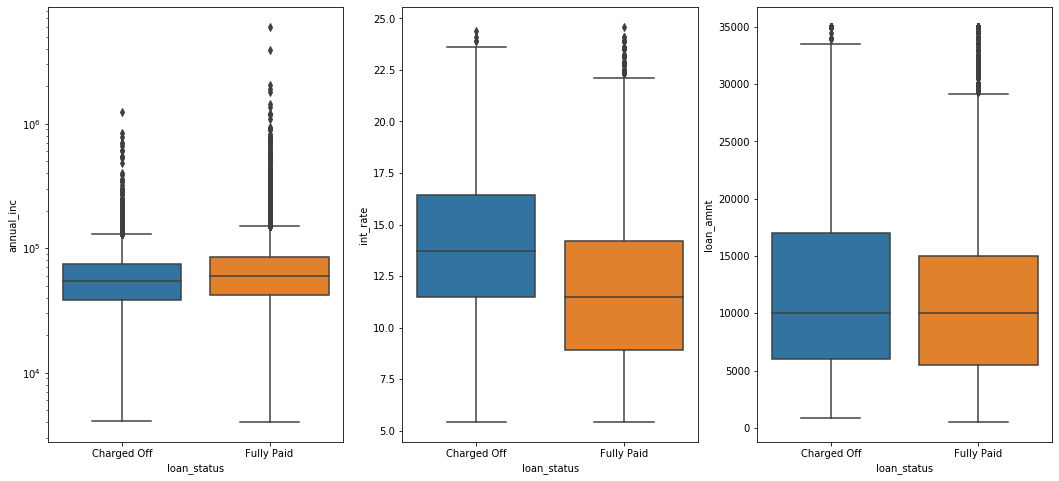

In [5]:
fig, ax=plt.subplots(1,3, figsize=(18,8))
sns.boxplot(y='annual_inc', x='loan_status', data=df, ax=ax[0]).set_yscale('log')
sns.boxplot(y='int_rate', x ='loan_status', data = df, ax=ax[1])
sns.boxplot(y='loan_amnt', x='loan_status', data=df, ax=ax[2])

### Exercise 1: (7 min)
    
#### 1.1 (3 min)

What do you observe from the boxplots above? 

**Answer.** One possible solution is shown below:

We can see a slight increase in the median of annual income when comparing fully-paid users to charged-off users. In addition, the difference between charged-off users and fully-paid users in the distribution of `int_rate` is more drastic. The boxplot for fully-paid users is lower than the one for charged-off users. This result is as expected as higher interest rates would increase the actual amount of money a user would have to pay.

Finally, we don't see a clear change in the distribution of `loan_amnt`. Users who fully paid their debts seem to have slightly lower loan amounts on average.

#### 1.2 (4 min)

Consider the statement:

> "From these plots we can conclude that annual income does not play a significant role in deciding if a user will or will not pay back his loan."

Do you think this statement is correct? How would you attempt to verify this? 

**Answer.** One possible solution is shown below:

From the plot itself we cannot make such a statement. Nevertheless, the annual income median being slightly higher for fully-paid users indicates that annual income may be relevant when studying loan applications. In order to verify this, we could run a two-sample $t$-test and check if the *means* are different:  

In [6]:
a=df[df['loan_status']=="Charged Off"]['annual_inc']
b=df[df['loan_status']=="Fully Paid"]['annual_inc']
T,p=ttest_ind(a,b)
p

1.9075011302588803e-14

Since the $p$-value is small, there is enough statistical evidence to say that the two distributions have different means. This supports the idea of using annual income as a factor for deciding loan approvals. However, it is key to keep studying other possible interactions between the variables to fully answer this question. 

We learned in previous hypothesis testing cases that we can use contingency tables to examine the relationship between two discrete variables. A chi-square test can be performed based on the contingency table to verify if the observed relationship is statistically significant. The following function generates the contingency table between `loan_status` and another given variable named `var`:

In [7]:
def get_ct(df, var):
    ct_res = pd.crosstab(df[var], df['loan_status'], margins=True)
    ct_res['Fully Paid(%)'] = round( ct_res['Fully Paid']/ct_res['All']*100, 2)
    return ct_res.drop(columns='All')

For instance, let's compute the contingency table of `loan_status` versus `verification_status`:

In [8]:
get_ct(df, 'verification_status')

loan_status,Charged Off,Fully Paid,Fully Paid(%)
verification_status,,,
Not Verified,2050,14449,87.58
Source Verified,1413,8406,85.61
Verified,1977,10410,84.04
All,5440,33265,85.94


### Exercise 2: (12 min)

#### 2.1 (4 min)

What can you see from the table above? Can we conclude that income source verification is not necessary for our client?

**Answer.** One possible solution is shown below:

From the table, `verification_status` seems to have a counter-intuitive association with `loan_status` - the less reliable the income information is, the more likely a user would fully repay the debt, as reflected by the decreasing trend of fully paid proportions when `verification_status increases` trends from not verified to fully verified. At first glance, this indicates that source verification may be a waste of money for the client. However, we must be careful with our conclusions as this table is not taking into account other possible factors that may have an effect on users paying off their debts. For instance, it may be the case that a considerable portion of loans with smaller interest rates were given to non-verified users, which made it easier to pay off the loan.

#### 2.2 (4 min)

Use a chi-square test to verify if the observed associations between `verification_status` and `loan_status` are statistically significant.

**Hint:** Use  `chi2, p, dof, ex=chi2_contingency(pd.crosstab(index=x,columns=y))` to perform a chi-square test for a given pair of data `x, y`.

**Answer.** One possible solution is shown below:

In [9]:
chi2, p, dof, ex = chi2_contingency(pd.crosstab(index=df['verification_status'], columns=df['loan_status']))
print('verification_status: p-value of chisquare test =', p)

verification_status: p-value of chisquare test = 6.884998281535999e-17


The chi-square test verifies that the associations between `verfication_status` and `loan_status` are indeed statistically significant.

#### 2.3 (4 min)

Consider the following statements:

> I. "Since the chi-square test for the contingency table of `verification_status` vs. `loan_status` is significant, the decreasing trend of probability of pay-off is not likely due to randomness."

> II. "Since there is a significant difference between the probability of full payment in users with no verified income and users with verified income based on the chi-square test, we should always enforce income verification."

Are the statements correct?

**Answer.** One possible solution is shown below:

Statement I is not correct. The chi-sqaure test is not a trend test, it only suggests that there is significant difference in the probability of pay-off among the three levels of `verification_status`, but it cannot further verify that the differences form a specific trend.

Statement II is not correct since it implies a causal relationship between `verification_status` and `loan_status`. There is not enough evidence to deduce this, and we should first assess if there are potential confounding variables like we did in previous cases before making such a strong conclusion.

### Stratified contigency tables of `verification_status` vs. `loan_status` (15 min)

As we saw in the previous exercise, we need to adjust for other variables in order to remove potential confounding impacts. If we want to know if `verification_status` really is associated with `loan_status` as indicated by the contigency table above, we should consider stratifying the contingency table between `loan_status` and `verification_status` by other variables that are also associated with `loan_status`.

### Exercise 3: (10 min)

Write a function to generate a contingency table for `verification_status` vs. `loan_status` stratified by the `stra_var`, the argument of the function. Make sure to include a column for the proportion of fully-paid users in each level of `verification_status`. Use this function to examine the relationship between `verification_status` and `loan_status` when adjusting for `home_ownership` and `term`. Do we still see the same trend across different levels of `home_ownership` and `term`?

**Hint:** When using the `index` parameter of `pd.crosstab()` with two variables, the contingency table will be stratified by the first variable in `index`.

**Answer.** One possible solution is shown below:

In [10]:
def get_ct_stra(stra_var):
    ct_stra = pd.crosstab(index=[stra_var,df.verification_status], columns = df.loan_status, margins = True)
    ct_stra['Fully Paid (%)'] = round(ct_stra['Fully Paid']/ct_stra['All']*100,2)
    return ct_stra.drop(columns='All').drop('All', level=0)

In [11]:
get_ct_stra(df.home_ownership)

loan_status                         Charged Off  Fully Paid  Fully Paid (%)
home_ownership verification_status                                         
RENT           Not Verified                1072        7133           86.93
               Source Verified              815        4332           84.17
               Verified                     865        4290           83.22
MORTGAGE       Not Verified                 798        6064           88.37
               Source Verified              487        3443           87.61
               Verified                     983        5480           84.79
OWN            Not Verified                 170        1210           87.68
               Source Verified              110         622           84.97
               Verified                     122         611           83.36
OTHER          Not Verified                  10          42           80.77
               Source Verified                1           9           90.00
               Verified                       7          29           80.56

In [12]:
get_ct_stra(df.term)

loan_status                     Charged Off  Fully Paid  Fully Paid (%)
term       verification_status                                         
 36 months Not Verified                1580       12574           88.84
           Source Verified              688        6132           89.91
           Verified                     805        6505           88.99
 60 months Not Verified                 470        1875           79.96
           Source Verified              725        2274           75.83
           Verified                    1172        3905           76.92

We can see the trend is preserved when stratified by `home_ownership`. The proportion of fully paid users decreases as the verification status gets less reliable regardless of levels of `home_ownership`. The exception is level `OTHER`. But since we have very few users there, we should not put too much confidence on the results. The trend is no longer preserved in both levels of `term`. We can see the proportion of fully paid users with shorter loan term (36 months) remains the same across different levels of `verification status` at around 88%.

### Exercise 4: (5 min)

Comparing the stratified contigency tables to the unstratified counterparts, which of the following conclusions is correct? Select all that apply.

I. Based on the stratified contigency table, the difference in the probability of full payment between income-verified and not income-verified users might be attributable to the effect of loan term on the probability of full payment.

II. Based on the stratified contigency table, the difference in the probability of full payment between income-verified and not income-verified users is not likely attributable to the effect of home ownership on the probability of full payment.

III. Assume users with no income verified are more likely to borrow short term loans compared to users with verified income and users with short term loans are more likely to pay back their debts. If in fact income verification status has no effect on the probability of paying back one's debt, users with no verified income are on the margin still more likely to pay off their debt.

**Answer.**

Statement I is correct. As we see in the stratified table by `term`, the proportion of fully paid loans remains the same across different levels of verification status when `term` is fixed. On the other hand, the stratum-specific probability of full payment is quite different from stratum to stratum.

Statement II is correct since stratifying the contingency table by `home_ownership` does not significantly change the proportions of fully-paid loans.

Statement III is correct by definition, and in fact might be the reason why we observed the counter-intuitive trend. We can see the users with no verified income have many more short-term loans, while the stratified contigency table told us that users with longer loan terms are less likely to pay off their debts compared to short-term loan borrowers.

In [13]:
pd.crosstab(df['term'], df['verification_status'])

verification_status,Not Verified,Source Verified,Verified
term,,,
36 months,14154,6820,7310
60 months,2345,2999,5077


In [14]:
df.columns

Index(['loan_status', 'annual_inc', 'verification_status', 'emp_length',
       'home_ownership', 'int_rate', 'loan_amnt', 'purpose', 'term', 'grade'],
      dtype='object')

## Extracting additional information with linear regression (12 min)

From the chi-square test, we know that verification status is marginally associated with the probability of pay-off. We observed from the contingency table that this probability increases when the information about income becomes less reliable. However, this observation cannot be verified with just the standard chi-square test.
    
As a first approximation, let's create a linear model that aims to explain `loan_status` using the variables given in our dataset. Notice that `loan_status` is a categorical variable, so it is necessary to dummify it first. In addition, since the variables `verification_status`, `grade` and `term` are ordinal, we could use their categorical codes as well (this would assume that jumps in the categories are equal, which might be reasonable for some of these variables). Finally, in order to avoid large numbers appearing in the coefficients of the regression, let's normalize the numerical data. This procedure does not affect the outcome of the regression - OLS is invariant under linear transformations:

In [15]:
df2=df.copy()

var_names=['loan_status','verification_status','grade','term']
for var in var_names:
    df2[var]=df2[var].cat.codes
    
var_names2=['annual_inc','int_rate','loan_amnt']
for var in var_names2:
    df2[var]=(df2[var]-df2[var].mean())/df2[var].std()

Let's consider a simple model using the variables `annual_inc`, `verification_status`, `loan_amnt`, `int_rate` and `term`:

In [16]:
model1 = 'loan_status~verification_status+annual_inc+loan_amnt+int_rate+term'
lm1   = sfm.ols(formula = model1, data = df2).fit()
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:            loan_status   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     385.5
Date:                Tue, 23 Jun 2020   Prob (F-statistic):               0.00
Time:                        17:34:51   Log-Likelihood:                -13075.
No. Observations:               38705   AIC:                         2.616e+04
Df Residuals:                   38699   BIC:                         2.621e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.8763    

### Exercise 5: (7 min)

#### 5.1 (4 min)

What can you conclude from these results?

**Answer.** Here is one possible answer.

We see that `verification_status` has a positive coefficient in the regression; however, the observed $p$-value is very large! Thus, if we account for other variables in a linear regression, there is not enough statistical evidence in our sample to say that there exists an interaction between `verification_status` and `loan_status`. In fact, if we run the same model, but this time without using `verification_status` we obtain a model with the same R-squared:

In [17]:
model2 = 'loan_status~annual_inc+loan_amnt+int_rate+term'
lm2   = sfm.ols(formula = model2, data = df2).fit()
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:            loan_status   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     481.9
Date:                Tue, 23 Jun 2020   Prob (F-statistic):               0.00
Time:                        17:34:52   Log-Likelihood:                -13075.
No. Observations:               38705   AIC:                         2.616e+04
Df Residuals:                   38700   BIC:                         2.620e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8768      0.002    415.307      0.0

Nevertheless, this model explains only 4.7% of the total variation of `loan_status`, which is quite low.

#### 5.2 (3 min)

What disadvantages do you think a linear regressor had in this situation?

**Answer.** Here is one possible answer.

Using a linear regression model in this context can be a little disadvantageous as our target variable is binary. This additional constraint is never used when building linear models! We should be able to better explain the behavior of `loan_status` with models that takes this vital information into account.

This idea is better explained with an image. Consider the data given below. What curve would you use to model the binary data provided?

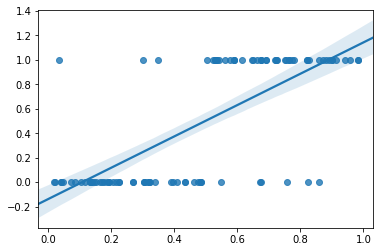

In [18]:
p=np.random.rand(100)
x=np.random.rand(100)
y=np.logical_or(np.logical_and(x<=0.5, p>0.8), np.logical_and(x>0.5, p<=0.8)).astype(int)

sns.regplot(x,y)

### Question: (3 min)

From first principles, how would you go about creating a model that decides whether a user will or not be able to pay his loan?

## Logistic regression: extending the linear model to binary outcomes (60 min)

The logistic regression model is a modified version of the standard linear regression model that deals with classification problems, where the outcomes are binary variables (in this case, whether the loan was paid off or charged off). To understand a logistic regression model, let's first introduce the idea of **odds**. The odds of an event is the ratio of its success probability to its failure probability. In our case, the odds of fully paying the debt is defined as

$$
\text{Odds}(\text{Full payment}) = \frac{p}{1-p}.
$$

where $p$ is the probability of pay-off. For example, the odds of obtaining `Heads` after *perfectly tossing* a fair coin equals $1$, the odds of obtaining a `two` after the toss of a pair of *fair* dice is $\frac{1}{36}$, but the odds of obtaining a `Heads` after tossing a real coin faced up `Heads` is [$\frac{51}{49}\approx 1.04$](https://www.youtube.com/watch?v=AYnJv68T3MM).

It turns out that it is easier to work with odds than probabilities. To investigate our question about trend in probability of pay-off $p$, we assume the odds is a function of income verification status:

\begin{equation}
\log(\text{Odds}) = \beta_0 + \beta_1*\text{verification_status}. \tag{1}
\end{equation}

In order to reflect that there is a trend over different verification statuses, we code different levels of `verification_status` using integers: "Not Verified" as 0, "Source Verified" as 1 and "Verified" as 2; i.e. we are renaming categories of a categorical variable to reflect a clear numerical trend. We assert that this coding scheme implies that if $\beta_1$ is positive, then there is an increasing trend of pay-off probability as income verification status becomes more reliable. On the other hand, if $\beta_1$ is negative, the opposite is true.

Once we fit the model in (1), we can perform a test to examine if $\beta_1$ is significantly different from zero. Note if $\beta_1=0$, then $p$ is the same for different levels of `verification_status` and thus no trend is present. If $\beta_1$ is significantly different from zero, we can use the estimated sign of $\beta_1$ to determine the direction of the trend.

Let's see how one can run a logistic regression model using the `statsmodels.api` function `Logit`:

In [19]:
# code the discrete variable by the specification above
df_log1 = pd.DataFrame(columns=['verification_status','loan_status'])
df_log1['verification_status'] = df.verification_status.cat.codes
df_log1['loan_status'] = df.loan_status.cat.codes
df_log1['Intercept'] = 1

logit = sm.Logit(df_log1['loan_status'], df_log1[['Intercept','verification_status']])
logit_res = logit.fit()
logit_res.summary()

Optimization terminated successfully.
         Current function value: 0.405007
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            loan_status   No. Observations:                38705
Model:                          Logit   Df Residuals:                    38703
Method:                           MLE   Df Model:                            1
Date:                Tue, 23 Jun 2020   Pseudo R-squ.:                0.002350
Time:                        17:34:58   Log-Likelihood:                -15676.
converged:                       True   LL-Null:                       -15713.
Covariance Type:            nonrobust   LLR p-value:                 8.419e-18
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.9469      0.022     88.290      0.000       1.904       1.990
verification_status    -0.1460      0.017     -8.600      0.000      -0.179      -0.113
=======================================================================================
"""

### Interpretation of the coefficients in the output of a logistic regression (5 min)

Although the logistic regression model comes with more complexity than standard linear regression, the sign of the regression coefficient still represents the direction of influence of a specific variable: a positive coefficient means the probability of pay-off will increase if the associated variable increases and vice versa.

The other important part of information when interpreting a logistic regression model is the $p$-value for each regression coefficient. The p-value indicates the result of the following hypothesis test:

$$
H_0: \beta = 0~vs.~ H_A: \beta \neq 0.
$$

The test determines if the difference in the probability of pay-off is associated with changes in the corresponding variable.

Sometimes you might find that both the $p$-value and the estimated effect size (regression coefficient) for a variable is small. You should be cautious about this situation as $p$-values are not the only way to determine if variables are important.

For instance, from the results shown above for the model `logit_res`, the coefficients indicate that when `verfication_status` increases by 1, the odds of pay-off decreases by 14%. Since the $p$-value for the coefficient is smaller than 0.05, we can conclude that the decreasing trend we observed from the table is not likely due to randomness.

An important output above is `Pseudo R-squ.`. This metric is similar to R-squared for linear models. If this number is large, then the variables in the model explain a large portion of the drivers of people's tendency to pay off their debt. In our case, the metric is only 0.2%, which means that we have a lot of room to improve.

### Geometric interpretation of logistic regression (15 min)

Logistic regression is easily turned into a **classifer** by choosing a **decision boundary**. That is, picking a cut-off value $c=\log\left(\frac{p}{1-p}\right)$, we can classify using the following rule:

> if $\beta_0 + \beta_1*\text{verification_status} > c$ then Fully Paid; or

> if $\beta_0 + \beta_1*\text{verification_status} \leq c$ then Charged Off

The curve which separates defaulters and non-defaulters, which is defined by the equation $\beta_0 + \beta_1$ `verification_status` $=\log\left(\frac{p}{1-p}\right)$, is the decision boundary determined by model (1) and cut-off value $p$. For example, using the results found above, if we set $p = 0.5$ then:  

> User would be classified as Fully Paid if $\text{verification_status} >\frac{-\beta_0}{\beta_1}\approx 13.334931506849317$

> User would be classified as Charged Off if $\text{verification_status} \leq \frac{-\beta_0}{\beta_1}\approx 13.334931506849317$

Clearly, this decision boundary is useless as we know that the values `verification_status` are always at most $2$ for every user. Thus, we would need to figure out what value for $p$ is gives us the best classification possible. We will expand on this later.  

### Exercise 6: (12 min)

#### 6.1 (7 min)

Run a logistic regression model for `loan_status` using as regressors the variables `loan_amnt` and `int_rate`. Normalize these two variables before fitting the model.

**Answer.** Here is one possible answer:

In [20]:
# code the discrete variable by the specification above
df6=df.copy()
df6['loan_status'] = df6.loan_status.cat.codes
df6['loan_amnt']=(df6['loan_amnt']-df6['loan_amnt'].mean())/df6['loan_amnt'].std()
df6['int_rate']=(df6['int_rate']-df6['int_rate'].mean())/df6['int_rate'].std()
df6['Intercept'] = 1

logit2 = sm.Logit(df6['loan_status'], df6[['Intercept','loan_amnt','int_rate']])
logit_res2 = logit2.fit()
logit_res2.summary()

Optimization terminated successfully.
         Current function value: 0.386118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            loan_status   No. Observations:                38705
Model:                          Logit   Df Residuals:                    38702
Method:                           MLE   Df Model:                            2
Date:                Tue, 23 Jun 2020   Pseudo R-squ.:                 0.04888
Time:                        17:35:03   Log-Likelihood:                -14945.
converged:                       True   LL-Null:                       -15713.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9277      0.016    119.842      0.000       1.896       1.959
loan_amnt      0.0399      0.015      2.664      0.008       0.011       0.069
int_rate      -0.5862      0.016    -36.901      0.000      -0.617      -0.555
==============================================================================
"""

#### 6.2 (5 min)

Use the coefficients found in Exercise 6.1 to run the code below. Move your cursor to see the changes in the decision boundary.

<IPython.core.display.Javascript object>


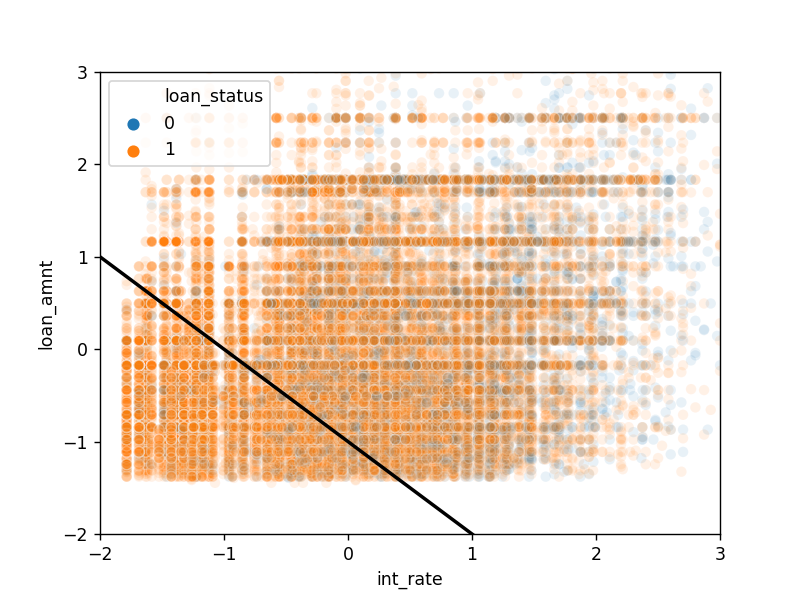

interactive(children=(FloatSlider(value=0.5, description='p', max=0.99, min=0.01, step=0.01), Output()), _dom_…

<function __main__.update(p=0.5)>

In [21]:
b_Intercept=1 #Here your coeff
b_loan_amnt=1 #Here your coeff
b_int_rate=1 #Here your coeff


df6=df.copy()
df6['loan_status'] = df6.loan_status.cat.codes
df6['loan_amnt']=(df6['loan_amnt']-df6['loan_amnt'].mean())/df6['loan_amnt'].std()
df6['int_rate']=(df6['int_rate']-df6['int_rate'].mean())/df6['int_rate'].std()
df6['Intercept'] = 1

import ipywidgets as widgets
from ipywidgets import interact
%matplotlib notebook

fig, ax = plt.subplots()
sns.scatterplot(x='int_rate',y='loan_amnt',hue='loan_status',data=df6,alpha=0.1,ax=ax)
plt.xlim(-2,3)
plt.ylim(-2,3)
plt.legend()


p=0.5
x1=np.arange(-2,40,3)
y1=(1/b_loan_amnt)*(np.log(p/(1-p))-b_Intercept-b_int_rate*x1)
l, = plt.plot(x1, y1, lw=2, color='k', label='Current Decision boundary')

def update(p=0.5):
    y1=(1/b_loan_amnt)*(np.log(p/(1-p))-b_Intercept-b_int_rate*x1)
    l.set_ydata(y1)
    fig.canvas.draw_idle()

interact(update, p=widgets.FloatSlider(value=p,min=0.01,max=0.99,step=0.01))

In [22]:
%matplotlib inline

**Answer.**

<IPython.core.display.Javascript object>


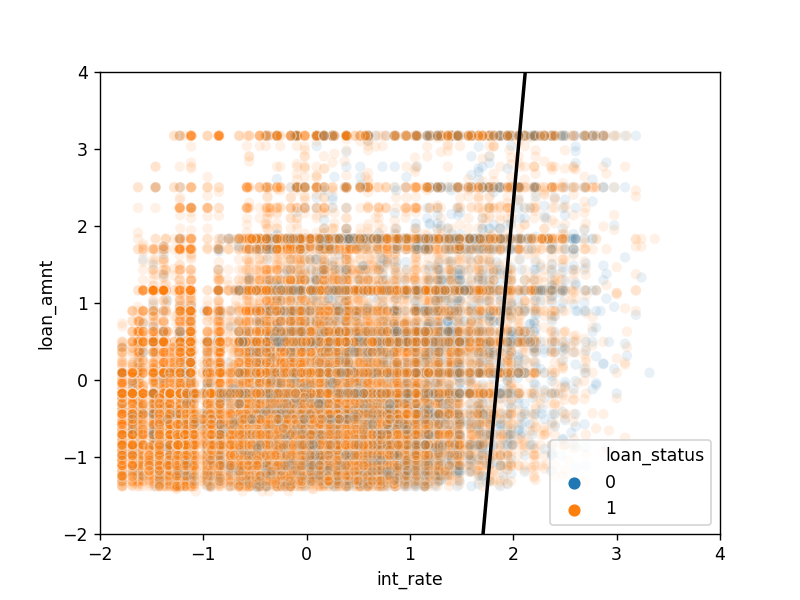

interactive(children=(FloatSlider(value=0.7, description='p', max=0.99, min=0.01, step=0.01), Output()), _dom_…

<function __main__.update(p=0.7)>

In [22]:
b_Intercept=1.9277 #Here your coeff
b_loan_amnt=0.0399 #Here your coeff
b_int_rate=-0.5862 #Here your coeff


df6=df.copy()
df6['loan_status'] = df6.loan_status.cat.codes
df6['loan_amnt']=(df6['loan_amnt']-df6['loan_amnt'].mean())/df6['loan_amnt'].std()
df6['int_rate']=(df6['int_rate']-df6['int_rate'].mean())/df6['int_rate'].std()
df6['Intercept'] = 1

import ipywidgets as widgets
from ipywidgets import interact
%matplotlib notebook

fig, ax = plt.subplots()
sns.scatterplot(x='int_rate',y='loan_amnt',hue='loan_status',data=df6,alpha=0.1,ax=ax)
plt.xlim(-2,4)
plt.ylim(-2,4)
plt.legend()


p=0.7
x1=np.arange(-2,40,3)
y1=(1/b_loan_amnt)*(np.log(p/(1-p))-b_Intercept-b_int_rate*x1)
l, = plt.plot(x1, y1, lw=2, color='k', label='Current Decision boundary')

def update(p=0.7):
    y1=(1/b_loan_amnt)*(np.log(p/(1-p))-b_Intercept-b_int_rate*x1)
    l.set_ydata(y1)
    fig.canvas.draw_idle()

interact(update, p=widgets.FloatSlider(value=p,min=0.01,max=0.99,step=0.01))

### Evaluating the logistic regression model (15 min)

A major drawback of the pseudo $R^2$ metric is that it cannot be directly translated into the prediction accuracy of a model. Remember that the goal of our whole analysis is to predict whether or not a user is going to pay off his debt. But how do we evaluate if the predication is accurate or not? This question is not as simple as it seems and the reason is because logistic models only produce probabilities while what we observed are binary labels.

A straightforward solution is that you can select a cut-off value for the predicted probability such that people with probabilities smaller than the cut-off value are deemed as defaulters. This converts the probabilities into binary labels, after which we can see if the predicted labels are the same as the observed labels to measure prediction accuracy.

### Question: (5 min)

How might you go about selecting the best cut-off value for a given logistic regression model?

**Answer.** One way to do this is with the concepts of `true positive rate` (TPR) and `true negative rate` (TNR). In our context, TPR measures the proportion of people who paid off their debt that are correctly identified by our model, whereas TNR measures the proportion of defaulters that are correctly identified as defaulters.

There is a constant trade-off between TPR and TNR. It is usually hard to find a rule with high TPR and TNR at the same time. People will choose to prioritize one of them based on the particular scenario. For instance, in our case, TNR is usually more important than TPR since we would rather avoid lending to defaulters than miss lending to one good candidate.

### Exercise 7: (10 min)

Calculate the TPR and TNR for the model in Exercise 6 using cut-off values $p = 0.8, 0.85, 0.9$. Which of these cut-off values do you think is better? Why?

**Answer.** Here is one possible answer:

In [23]:
b_Intercept=1.9277 
b_loan_amnt=0.0399 
b_int_rate=-0.5862 

def rates(p):
    a= df6.loan_status
    b=(b_Intercept+b_loan_amnt*df6['loan_amnt']+b_int_rate*df6['int_rate']>np.log(p/(1-p))).astype('int')
    
    TPR=(a & b).sum(axis=0)/a.sum(axis=0)
    TNR=(1-a & 1-b).sum(axis=0)/(1-a).sum(axis=0)
    return [TPR,TNR]

print('p=0.8 ',rates(0.8))
print('p=0.85 ',rates(0.85))
print('p=0.9 ', rates(0.9))

p=0.8  [0.8393506688711859, 0.33400735294117645]
p=0.85  [0.6668570569667819, 0.5494485294117647]
p=0.9  [0.35484743724635504, 0.8457720588235295]


From here, we see that choosing a cut-off of $p = 0.8$ gives a high TPR and low TNR. This means that this cut-off would correctly classify most good borrowers, but would also miss a considerable number of defaulters. As stated above, this can be problematic as we might end up losing money. 

On the other extreme, $p = 0.9$  would correctly detect a good portion of defaulters, but would also deny many loans to users that will probably pay. Thus, we may end up losing clients to our competitors and miss the opportunity to work with good loaners.

In a more conservative approach, $p = 0.85$ would correctly detect 66% of good loaners and around 54% of defaulters. This could be an alternative as we would not miss much of our potential clients and our risk would be relatively controlled. Nevertheless, we should probably consult with our client on this decision as he might prefer a safer or riskier approach.

### The Receiver Operating Characteristic (ROC) curve (15 min)

We have seen the great potential in considering the TPR and TNR to help select the appropriate threshold for our models. However, it does not makes much sense to compute these for single cut-off values. We ought to summarize the prediction accuracy across all different cut-off values to produce a unified evalution of our model. This is the motivation for the **receiver operating characteristic (ROC) curve**.

The ROC curve plots 1 - TNR against TPR and illustrates the behavior of a logistic model as the cut-off point changes. Let's plot the ROC curve for the model in Exercise 6:

<IPython.core.display.Javascript object>


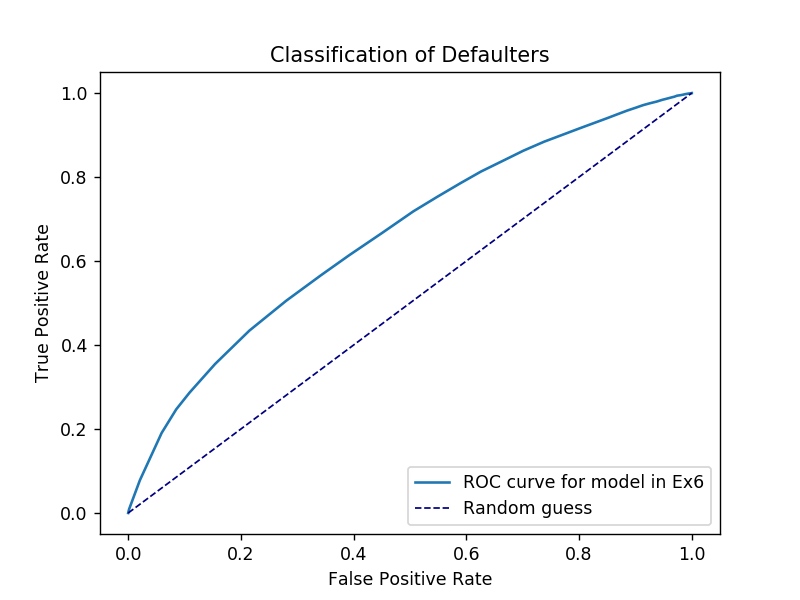

In [24]:
#This function calculates the TPR and TNR for given p
def rates(p):
    a= df6.loan_status
    b=(b_Intercept+b_loan_amnt*df6['loan_amnt']+b_int_rate*df6['int_rate']>np.log(p/(1-p))).astype('int')
    
    TPR=(a & b).sum(axis=0)/a.sum(axis=0)
    TNR=(1-a & 1-b).sum(axis=0)/(1-a).sum(axis=0)
    return [TPR,TNR]

#Then, we use this function to plot the ROC curve
x=[]
y=[]
for p in np.arange(0.01,0.99,0.01):
    z=rates(p)
    y.append(z[0])
    x.append(1-z[1])
    
fig, ax = plt.subplots()

ax.plot(x,y, label=f'ROC curve for model in Ex6')
ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Defaulters')
plt.legend(loc='lower right')

### Exercise 8: (10 min)

Draw the ROC curves for `logit_res` and the model in Exercise 6 on the same plot. Can you determine which model is better by solely looking at these plots? Propose a way to evaluate different models using ROC curves.

**Hint:** Use `logit_res.predict(df_log1[['Intercept','verification_status']])` to compute the predicted probabilities of model `logit_res`. Call this result `predict_p` and use the function `roc_cure(df_log1['loan_status'],predict_p)` to compute the coordinates of the ROC curve of the model.

**Answer.** Here is one possible answer:

<IPython.core.display.Javascript object>


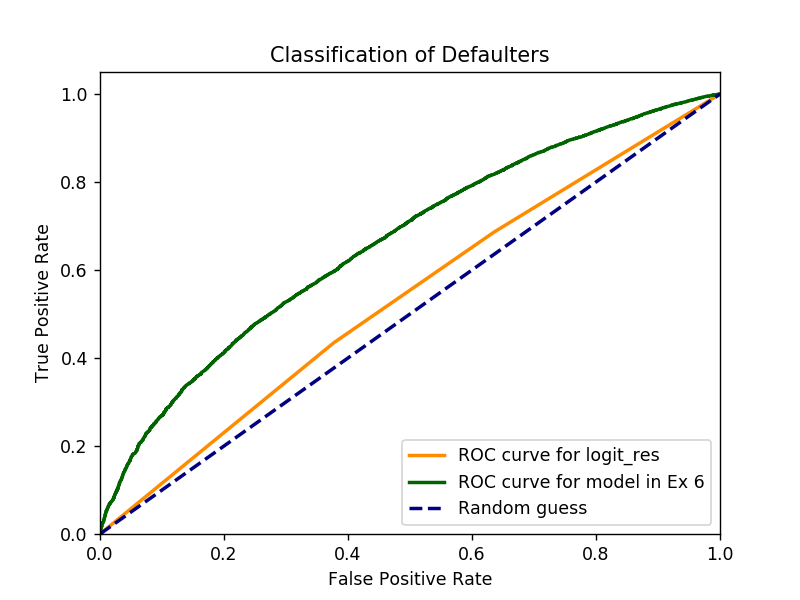

In [34]:
predict_p = logit_res.predict(df_log1[['Intercept','verification_status']])
predict_2_p = logit_res2.predict(df6[['Intercept','loan_amnt','int_rate']])
roc_p = roc_curve(df_log1['loan_status'], predict_p)
roc_2_p = roc_curve(df6['loan_status'], predict_2_p)

plt.figure()
line_width = 2
plt.plot(roc_p[0], roc_p[1], color='darkorange',
         lw=line_width, label=f'ROC curve for logit_res')
plt.plot(roc_2_p[0], roc_2_p[1], color='darkgreen',
         lw=line_width, label=f'ROC curve for model in Ex 6')
plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Defaulters')
plt.legend(loc='lower right')
plt.show()

We see that any choice of threshold for the model in Exercise 6 is strictly better than the model `logit_res`. Thus, the model in Exercise 6 will have much better classification rates. In fact, this gives us a simple way to determine when a model dominates another: we simply check if its ROC curve is always strictly above the ROC curve of the latter at every point.

### Comparing models using the area under the curve (AUC) (5 min)

One way to summarize the whole ROC cruve is by computing the **area under the curve (AUC)**. Roughly speaking, AUC indicates the probability that a randomly selected defaulter will have smaller **$p$** than a randomly selected non-defaulter.

If AUC is close to one, then the rule is close to a perfect rule. The ROC curve for a random guess rule (set $p = 0.5$ for all applicants) is the diagonal line in the plot and usually serves as a baseline to check if the classification model learns any information from the data above and beyond pure randomness. We can compute the AUC after calculation of the ROC curve using the function `auc` from `sklearn.metrics`:

In [26]:
#Note, here we assumed you named the roc curves of Exercise 8 roc_p and roc_2_p

auc_p = auc( roc_p[0], roc_p[1] )
auc_2_p = auc( roc_2_p[0], roc_2_p[1] )

print('AUC of `log_res`: ', auc_p)
print('AUC of the model of Ex 6: ', auc_2_p)

AUC of `log_res`:  0.5340366188185781
AUC of the model of Ex 6:  0.6615528294400581


We can see that the model of Exercise 6 is far superior to our first logistic regression model.

## Adding additional variables to the model (15 min)

In the previous sections, we observed a decreasing trend in pay-off probability associated with more reliable income information. However, this trend is counterintuitive. This might be because many other factors are also associated with the probability of pay-off, as we have seen in the exploratory analyses and somewhat in our naive linear regression model. Not accounting for these factors will result in completely different conclusions regarding the effect of `verification_status`.

Using the function `get_ct`, which is used to compute the contingency tables of the categorical variables, it is not hard to see that except for `annual_inc`, all other variables in the dataset are correlated with `verification_status`. For example, there seems to be a strong correlation between `verification_status` and `loan_amnt`. People with no verified income source tend to borrow less money than people with verified income source. This might be the reason for the decreasing trend associated with `verification_status`, since smaller loans are more likely to be paid off. Let's now incorporate all these variables (including `annual_inc` for now) into the logistic model along with `verification_status` and see if the decreasing trend associated with `verification_status` is still present:

In [27]:
# Preprocessing the variables
df_log2 = pd.concat([(df.loan_amnt - df.loan_amnt.mean())/df.loan_amnt.std(),\
                     (df.int_rate - df.int_rate.mean())/df.int_rate.std(),\
                     (df.annual_inc - df.annual_inc.mean())/df.annual_inc.std(),\
                     pd.get_dummies(df.home_ownership, prefix='home', drop_first=True), \
                     pd.get_dummies(df.purpose, prefix='purpose', drop_first=True), \
                     pd.get_dummies(df.grade, prefix='grade',drop_first=True)], axis=1)
df_log2['verification_status'] = df.verification_status.cat.codes
df_log2['emp_length'] = df.emp_length.cat.codes
df_log2['term'] = df.term.cat.codes
df_log2['Intercept'] = 1

In [28]:
logit_full1 = sm.Logit(df.loan_status.cat.codes, df_log2)
logit_full1_res = logit_full1.fit()
logit_full1_res.summary()

Optimization terminated successfully.
         Current function value: 0.378075
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                38705
Model:                          Logit   Df Residuals:                    38676
Method:                           MLE   Df Model:                           28
Date:                Tue, 23 Jun 2020   Pseudo R-squ.:                 0.06869
Time:                        17:35:39   Log-Likelihood:                -14633.
converged:                       True   LL-Null:                       -15713.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
loan_amnt                     -0.0075      0.019     -0.389      0.697      -0.045       0.030
int_rate                      -0.4050      0.054     -7.454      0.000      -0.511      -0.299
annual_inc                     0.3615      0.031     11.641      0.000       0.301       0.422
home_MORTGAGE                  0.0382      0.035      1.095      0.273      -0.030       0.107
home_OWN                       0.0209      0.060      0.348      0.728      -0.097       0.138
home_OTHER                    -0.4454      0.268     -1.660      0.097      -0.971       0.080
purpose_credit_card            0.0364      0.100      0.363      0.717      -0.160       0.233
purpose_debt_consolidation    -0.2190      0.091     -2.405      0.016      -0.398      -0.041
purpose_educational           -0.5663      0.178     -3.186      0.001      -0.915      -0.218
purpose_home_improvement      -0.1624      0.107     -1.523      0.128      -0.371       0.047
purpose_house                 -0.3556      0.171     -2.077      0.038      -0.691      -0.020
purpose_major_purchase        -0.0024      0.114     -0.021      0.983      -0.227       0.222
purpose_medical               -0.3945      0.141     -2.794      0.005      -0.671      -0.118
purpose_moving                -0.4147      0.150     -2.766      0.006      -0.708      -0.121
purpose_other                 -0.4050      0.099     -4.105      0.000      -0.598      -0.212
purpose_renewable_energy      -0.7242      0.286     -2.530      0.011      -1.285      -0.163
purpose_small_business        -0.9414      0.105     -8.961      0.000      -1.147      -0.735
purpose_vacation              -0.4371      0.179     -2.439      0.015      -0.788      -0.086
purpose_wedding                0.1348      0.142      0.948      0.343      -0.144       0.414
grade_B                       -0.2733      0.074     -3.709      0.000      -0.418      -0.129
grade_C                       -0.3549      0.103     -3.448      0.001      -0.557      -0.153
grade_D                       -0.3775      0.132     -2.860      0.004      -0.636      -0.119
grade_E                       -0.2973      0.160     -1.859      0.063      -0.611       0.016
grade_F                       -0.3238      0.194     -1.669      0.095      -0.704       0.057
grade_G                       -0.1802      0.238     -0.757      0.449      -0.647       0.286
verification_status            0.0082      0.020      0.411      0.681      -0.031       0.047
emp_length                    -0.0147      0.004     -3.301      0.001      -0.023      -0.006
term                          -0.4520      0.037    -12.081      0.000      -0.525      -0.379
Intercept                      2.6163      0.123     21.216      0.000       2.375       2.858
==============================================================================================
"""

### Exercise 9: (5 min)

Based on the results of the logistic model with all variables included, which of the following conclusions is correct? Select all that apply.

I. There is no evidence that supports the association between probability of pay-off and verification status after accounting for other variables.

II. Loans borrowed for small business have the smallest pay-off probability.

III. The odds of pay-off in users with LendingClub grade B decreases by 24% compared to users with grade A after accounting for other variables.

**Answer.**

Statement I is correct as the $p$-value for the variable `verification_status` is not smaller than 0.05.

Statement II is not correct as the statement does not account for the effects of other variables. For example, all small business applicants could have a very high income.

Statement III is correct as we can calculate it using the estimated coefficient. $e^{-0.2733} = 0.76$ which implies a 24% reduction.

### Why do we observe a marginal trend associated with verification_status? (7 min)

Interestingly, we find that the regression coefficient for `verification_status` is now positive and the $p$-value for it is very large (0.68). This indicates that after adjusting for all other variables in the dataset, `verification_status` is no longer significantly associated with the probability of pay-off. Let's now find out what confounding variables were responsible for introducing the initial decreasing trend that we observed.

We can investigate this problem using the regression results along with the correlation between `verification_status` and all other variables. First let's take a look at the pairwise relationship between `verification_status` and all other variables:

In [29]:
def get_rctable(var1, var2):
    res = pd.crosstab(df[var2], df[var1])
    chi2, p, dof, ex = chi2_contingency(res)
    output = round( res.div(res.sum(axis = 1),axis = 0)*100, 2 )
    return output.style.set_caption(f'{var1} vs. {var2}: Chi-square p-value={p:.2f}')

In [30]:
display(get_rctable('emp_length', 'verification_status'))
display(get_rctable('home_ownership', 'verification_status'))
display(get_rctable('purpose', 'verification_status'))
display(get_rctable('term', 'verification_status'))
display(get_rctable('grade', 'verification_status'))

emp_length,< 1 year,1 year,2 years,3 years,4 years,5 years,6 years,7 years,8 years,9 years,10+ years
verification_status,,,,,,,,,,,
Not Verified,12.09,9.41,12.43,11.1,8.98,8.59,5.67,4.44,3.82,3.33,20.13
Source Verified,15.08,8.52,11.22,10.71,8.72,8.48,5.77,4.65,3.54,3.03,20.25
Verified,8.99,6.92,10.02,9.81,8.94,8.35,5.88,4.72,4.08,3.32,28.98


home_ownership,RENT,MORTGAGE,OWN,OTHER
verification_status,,,,
Not Verified,49.73,41.59,8.36,0.32
Source Verified,52.42,40.02,7.45,0.1
Verified,41.62,52.18,5.92,0.29


purpose,car,credit_card,debt_consolidation,educational,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding
verification_status,,,,,,,,,,,,,,
Not Verified,4.77,13.47,43.51,1.35,7.17,0.83,6.15,1.8,1.42,12.1,0.19,3.95,0.99,2.29
Source Verified,4.59,12.03,46.27,0.33,7.35,1,6.02,2.08,2,9.31,0.38,4.57,1.1,2.98
Verified,2.11,12.95,52.9,0.51,7.93,1.08,4.13,1.36,1.03,7.48,0.21,5.53,0.65,2.13


term,36 months,60 months
verification_status,,
Not Verified,85.79,14.21
Source Verified,69.46,30.54
Verified,59.01,40.99


grade,A,B,C,D,E,F,G
verification_status,,,,,,,
Not Verified,30.34,31.98,20.83,11.63,3.93,1.03,0.27
Source Verified,25.3,29.43,19.95,13.97,7.76,2.87,0.71
Verified,17.8,28.5,20.53,15.52,11.31,4.71,1.64


In [31]:
sns.boxplot(y='loan_amnt', x='verification_status', data = df)

In [32]:
sns.boxplot(y='annual_inc', x='verification_status', data = df).set_yscale('log')

In [33]:
sns.boxplot(y='int_rate', x='verification_status', data = df)

### Exercise 10: (3 min)

Based on the relationships we observed in the contingency tables and the boxplots above, which of the following statements are correct? Select all that apply.

A. The marginal trend is that people with verified income tend to borrow loans with higher interest rates

B. The marginal trend is that people with verified income tend to have longer employment length

C. The marginal trend is that people with verified income tend to have mortgages

**Answer.** A and B are both correct since high interest rate and long employment length are both associated with lower probability of pay-off. C is not correct since home ownership is not significantly associated with probability of pay-off after controlling for other variables.

## Do we need to include `verification_status`? (10 min)

From the above, we might reach the conclusion that `verification_status` does not matter when we want to predict if a borrower is going to default on his/her debt. But does this mean that in the future, we can just ignore the verification status of an applicant when he/she is filing for a loan application through LC?

### Exercise 11: (3 min)

Which of following statements is true regarding what we should do with `verification_status`, based on the results we have so far?

A. Since the $p$-value for `verification_status` is large, we can remove it from our classification model and in the future, we do not need to collect this part of information from applicants.

B. Although the $p$-value for `verification_status` is large, the estimated regression coefficient for it is non-zero. We should keep the variable in the model and continue to collect the information in the future.

C. We should carry out an additional evaluation to compare the prediction accuracies of the model with and without `verification_status` before we can make any further decision.

D. None of the above.

**Answer.** A and B are both incorrect. We should not only base our decision based on the $p$-value alone. C is correct.

Let's evalute the prediction accuracy using ROC. The results are shown below:

In [ ]:
predict_withvs = logit_full1_res.predict(df_log2)
logit_full_novs = sm.Logit(df.loan_status.cat.codes, df_log2.loc[:, df_log2.columns != 'verification_status'])
predict_novs = logit_full_novs.fit(disp=0).predict(df_log2.loc[:, df_log2.columns != 'verification_status'])

roc_vs = roc_curve(df.loan_status.cat.codes, predict_withvs)
roc_novs = roc_curve(df.loan_status.cat.codes, predict_novs)
auc_vs = auc( roc_vs[0], roc_vs[1] )
auc_novs = auc( roc_novs[0], roc_novs[1])

plt.figure()
line_width = 2
plt.plot(roc_vs[0], roc_vs[1], color='darkorange',
         lw=line_width, label=f'With verification_status (AUC = {auc_vs:0.2f})')
plt.plot(roc_novs[0], roc_novs[1], color='darkgreen',
         lw=line_width, label=f'Without verification_status (AUC = {auc_novs:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Defaulters')
plt.legend(loc='lower right')
plt.show()

### Exercise 12: (5 min)

Based on all the results above, what can we conclude about the verification process?

**Answer.** We find that the AUC for the model with `verification_status` included is the same as the model without `verification_status` included (0.69). Since we always want our model to be as simple as possible, this means that we should not include `verification_status` as a variable when predicting if a user is likely to pay off his debt.

## Conclusions (3 min)

In this case, we investigated whether the verification status of applicants' income source is important when predicting if an applicant will pay off his/her debt. We constructed a logistic model to first examine the marginal relationship between verification status and probability of pay-off. We discovered a counterintuitive trend: less reliable income source information was correlated with higher pay-off probability. However, after fitting a larger logistic model with all independent variables that were available, we found that this trend was introduced via confounding effects of interest rate, annual income, and loan term.

After accounting for these variables, verification status was no longer significantly associated with pay-off probability. Based on $p$-values and the model ROC, we concluded that the verification process is irrelevant and we could potentially remove it from the required items and simplify the lending process.

## Takeaways (5 min)

In this case, we introduced the concept of **logistic regression** and how it can be used as a **classifier**. We did this by:

1. Performing EDA on a binary outcome using cross tables
2. Performing statstical tests to generate hypotheses
3. Codifying and testing these hypotheses with larger models using logistic regressions
4. Assessing classifier performance using AUC

Logistic regression naturally extends the concept of linear regression and is the benchmark model for performing classification tasks. The coefficients have similar interpretation as those of linear regression. ROC curves are then useful for comparing different classification models.

Logistic regression is only one of many different tools used in classification. While simple, it performs fairly well and needs relatively little data to train compared to other, more modern classifiers. While we only studied the binary case, there are extensions of logistic regression to handle multi-class and ordinal regression as well (you can read up on these in your own time).